# Helper Code

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn

#########################################################################
# Paper https://www.overleaf.com/read/phxxyvtdcypm
#########################################################################

## Download Dataset

In [ ]:
import zipfile
import os

#########################################################################
# Data from https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset
#########################################################################

if not os.path.exists("data.zip"):
    print("Downloading COVID-19 dataset")
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=144mXrLIHEHQgxTiGjYcapT_AzBLUK9Z2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=144mXrLIHEHQgxTiGjYcapT_AzBLUK9Z2" -O data.zip && rm -rf /tmp/cookies.txt

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

--2021-04-19 20:52:27--  https://docs.google.com/uc?export=download&confirm=HtaC&id=144mXrLIHEHQgxTiGjYcapT_AzBLUK9Z2
Resolving docs.google.com (docs.google.com)... 142.250.65.78, 2607:f8b0:4004:801::200e
Connecting to docs.google.com (docs.google.com)|142.250.65.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-4g-docs.googleusercontent.com/docs/securesc/94oaqfolmmaou5100d4k1ra88a9h5thj/vf25gp7ftebf56klqscb20ho9seeeoor/1618865475000/09716413299852285416/16715481158003185194Z/144mXrLIHEHQgxTiGjYcapT_AzBLUK9Z2?e=download [following]
--2021-04-19 20:52:27--  https://doc-0c-4g-docs.googleusercontent.com/docs/securesc/94oaqfolmmaou5100d4k1ra88a9h5thj/vf25gp7ftebf56klqscb20ho9seeeoor/1618865475000/09716413299852285416/16715481158003185194Z/144mXrLIHEHQgxTiGjYcapT_AzBLUK9Z2?e=download
Resolving doc-0c-4g-docs.googleusercontent.com (doc-0c-4g-docs.googleusercontent.com)... 172.217.7.129, 2607:f8b0:4004:805::2001
Connecting to doc-0c-4

In [ ]:
import torchvision
import torchvision.transforms as transforms

def initialize_loader(train, validate, train_batch_size, val_batch_size):
    # Transform dimensions
    transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
    covid_dataset = torchvision.datasets.ImageFolder('./data', transform=transform)
    n = len(covid_dataset)
    train_idx = int(train * n)
    val_idx = train_idx + int(validate * n)

    indices = np.arange(n)
    np.random.shuffle(indices)

    train_dataset = torch.utils.data.Subset(covid_dataset, indices[0:train_idx])
    val_dataset = torch.utils.data.Subset(covid_dataset, indices[train_idx:val_idx])
    test_dataset = torch.utils.data.Subset(covid_dataset, indices[val_idx:n])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=2)

    return train_loader, val_loader, test_loader

## Visualization

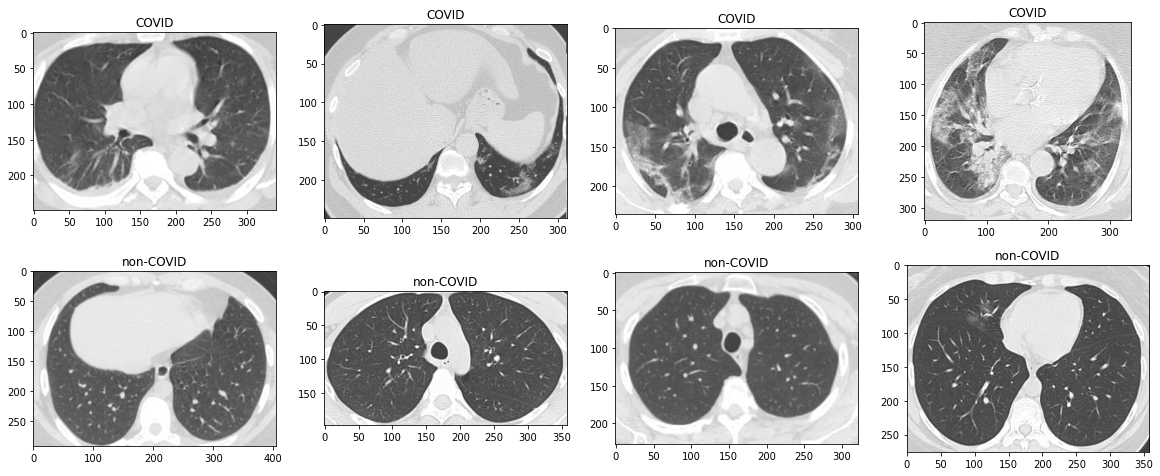

In [ ]:
import cv2

def visualize_dataset(col):
    fig = plt.figure(figsize=(20, 8))

    i = 0
    for c in range(col):
        for r, cat in enumerate(["COVID", "non-COVID"]):
            image = os.listdir(os.path.join("data", cat))[i]
            path = os.path.join("data", cat, image)

            fig.add_subplot(2, col, (c + 1) + (r * col))
            plt.title(cat)
            plt.imshow(cv2.imread(path))
        i += 1

visualize_dataset(4)

# Training Code

In [ ]:

def plot_fig(data, title):
    plt.figure()
    plt.plot(data['iteration'], data['train'], label='Train')
    plt.plot(data['iteration'], data['validate'], label='Validation')
    plt.legend()
    plt.title(title)
    plt.xlabel("Epochs")

def train(args, model, dataloaders, criterion, optimizer):
    # Numpy random seed
    np.random.seed(args["seed"])
    losses = {"iteration": range(args["epochs"]), "train": [], "validate": []}
    accuracies = {"iteration": range(args["epochs"]), "train": [], "validate": []}
    if args["gpu"]:
        model.cuda()

    for epoch in range(args_dict["epochs"]):
        for phase in ["train", "validate"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            total_correct = 0

            # Calculate FNR, FPR
            false_negatives = 0
            false_positives = 0
            num_covid = 0
            num_healthy = 0

            for i, (images, targets) in enumerate(dataloaders[phase]):
                if args_dict["gpu"]:
                    images = images.cuda()
                    targets = targets.cuda()

                # Zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    # Forward pass
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    total_loss += loss.item() * images.size(0)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    pred, pred_masks = outputs.max(dim=1, keepdim=True)
                    total_correct += torch.sum(pred_masks.reshape(-1,) == targets).data.item()
                    
                    false_negatives += torch.sum(pred_masks.reshape(-1,) < targets).data.item()
                    false_positives += torch.sum(pred_masks.reshape(-1,) > targets).data.item()

                    num_covid += torch.sum(targets == 1).data.item()
                    num_healthy += torch.sum(targets == 0).data.item()

            epoch_loss = total_loss / len(dataloaders[phase].dataset)
            accuracy = total_correct / len(dataloaders[phase].dataset)
            if phase == "validate":
                print("Validation Loss: ", epoch_loss, " Validation Accuracy: ", accuracy)
            losses[phase].append(epoch_loss)
            accuracies[phase].append(accuracy)

    plot_fig(losses, "Loss")
    plot_fig(accuracies, "Accuracy")
    return model

def test_model(model, gpu, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0.0, 0
    
    # Calculate FNR, FPR
    false_negatives = 0
    false_positives = 0
    num_covid = 0
    num_healthy = 0
    for i, (images, targets) in enumerate(dataloader):
        if gpu:
            images = images.cuda()
            targets = targets.cuda()

        with torch.no_grad():
            output = model(images.float())
            pred, pred_masks = output.max(dim=1, keepdim=True)
            
            total_correct += torch.sum(pred_masks.reshape(-1,) == targets).data.item()
            total_loss += criterion(output, targets).data.item()
            
            false_negatives += torch.sum(pred_masks.reshape(-1,) < targets).data.item()
            false_positives += torch.sum(pred_masks.reshape(-1,) > targets).data.item()
            num_covid += torch.sum(targets == 1).data.item()
            num_healthy += torch.sum(targets == 0).data.item()
    
    if false_positives + num_healthy > 0:
      print("False positive rate: {}".format(false_positives / (false_positives + num_healthy)))
    else:
      print("False positive rate: N/A")

    if false_negatives + num_covid > 0:
      print("False negative rate: {}".format(false_negatives / (false_negatives + num_covid)))
    else:
      print("False negative rate: N/A")
    return total_correct / len(dataloader.dataset), total_loss

# Model: ResNet-18

Validation Loss:  0.631660686385247  Validation Accuracy:  0.7258064516129032
Validation Loss:  0.5685417767493955  Validation Accuracy:  0.7862903225806451
Validation Loss:  0.4838769253223173  Validation Accuracy:  0.8104838709677419
Validation Loss:  0.4503339442514604  Validation Accuracy:  0.8145161290322581
Validation Loss:  0.40403673629606923  Validation Accuracy:  0.8306451612903226
Validation Loss:  0.3734835386276245  Validation Accuracy:  0.8467741935483871
Validation Loss:  0.36075610018545584  Validation Accuracy:  0.8467741935483871
Validation Loss:  0.3430170128422399  Validation Accuracy:  0.8467741935483871
Validation Loss:  0.32873123018972333  Validation Accuracy:  0.8608870967741935
Validation Loss:  0.3147211315170411  Validation Accuracy:  0.8669354838709677
Validation Loss:  0.3256413148295495  Validation Accuracy:  0.8649193548387096
Validation Loss:  0.2985613509531944  Validation Accuracy:  0.8709677419354839
Validation Loss:  0.3319763512380661  Validation A

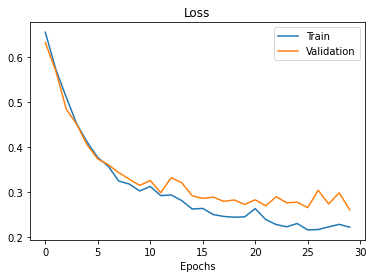

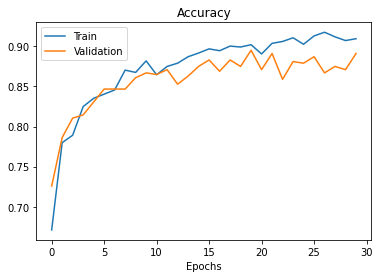

In [ ]:
import torchvision.models as models

# Set seeds for reproducibility
torch.manual_seed(18)
np.random.seed(18)

resnet18 = models.resnet18(pretrained=True)

# Repurpose Model
resnet18.requires_grad_(False)
resnet18.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.Linear(in_features=128, out_features=32, bias=True),
    nn.Linear(in_features=32, out_features=2, bias=True),
)

args_dict = {
    "seed": 413,
    "gpu": True,
    "epochs": 30,
    "learn_rate": 0.0001,
    "train_batch_size": 64,
    "val_batch_size": 64
}

train_loader, val_loader, test_loader = initialize_loader(0.7, 0.2, args_dict["train_batch_size"], args_dict["val_batch_size"])
dataloaders = {"train": train_loader, "validate": val_loader}

learned_parameters = []
for name, param in resnet18.named_parameters():
    if name.startswith("fc"):
        learned_parameters.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learned_parameters, lr=args_dict["learn_rate"], weight_decay=1e-4)

torch.cuda.empty_cache()
CovidRN18 = train(args_dict, resnet18, dataloaders, criterion, optimizer)

## Test performance

In [ ]:
test_acc, test_loss = test_model(CovidRN18, True, test_loader, criterion)
print("Test loss: ", test_loss, "Test accuracy: ", test_acc)

False positive rate: 0.11888111888111888
False negative rate: 0.08888888888888889
Test loss:  0.23584099113941193 Test accuracy:  0.8835341365461847


# Model: ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Validation Loss:  0.4339624931735377  Validation Accuracy:  0.7963709677419355
Validation Loss:  0.3969132996374561  Validation Accuracy:  0.8125
Validation Loss:  0.39195130428960245  Validation Accuracy:  0.8125
Validation Loss:  0.5065940974220153  Validation Accuracy:  0.7741935483870968
Validation Loss:  0.291590876156284  Validation Accuracy:  0.8709677419354839
Validation Loss:  0.5538288085691391  Validation Accuracy:  0.782258064516129
Validation Loss:  0.6081792904484656  Validation Accuracy:  0.7641129032258065
Validation Loss:  0.3813292384147644  Validation Accuracy:  0.8326612903225806
Validation Loss:  0.28539617912423226  Validation Accuracy:  0.875
Validation Loss:  0.2670561743359412  Validation Accuracy:  0.8891129032258065
Validation Loss:  0.3318950000309175  Validation Accuracy:  0.8588709677419355
Validation Loss:  0.47615617705929664  Validation Accuracy:  0.8185483870967742
Validation Loss:  0.27284378582431423  Validation Accuracy:  0.8850806451612904
Validat

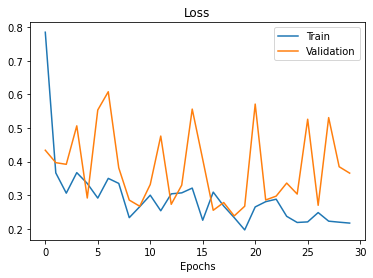

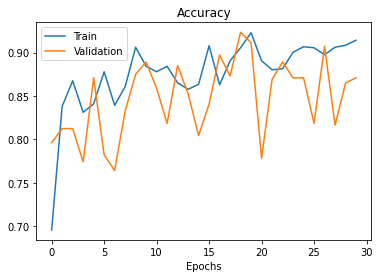

In [ ]:
import torchvision.models as models

# Set seeds for reproducibility
torch.manual_seed(50)
np.random.seed(50)

resnet50 = models.resnet50(pretrained=True)

# Repurpose Model
resnet50.requires_grad_(False)
resnet50.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.Linear(in_features=1024, out_features=2, bias=True)
)

args_dict = {
    "seed": 413,
    "gpu": True,
    "epochs": 30,
    "learn_rate": 0.001,
    "train_batch_size": 32,
    "val_batch_size": 32
}

train_loader, val_loader, test_loader = initialize_loader(0.7, 0.2, args_dict["train_batch_size"], args_dict["val_batch_size"])
dataloaders = {"train": train_loader, "validate": val_loader}

learned_parameters = []
for name, param in resnet50.named_parameters():
    if name.startswith("fc"):
        learned_parameters.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learned_parameters, lr=args_dict["learn_rate"], weight_decay=1e-4)

torch.cuda.empty_cache()
CovidRN50 = train(args_dict, resnet50, dataloaders, criterion, optimizer)

## Test Performance

In [ ]:
test_acc, test_loss = test_model(CovidRN50, True, test_loader, criterion)
print("Test loss: ", test_loss, "Test accuracy: ", test_acc)

False positive rate: 0.14893617021276595
False negative rate: 0.007692307692307693
Test loss:  0.2132059931755066 Test accuracy:  0.9116465863453815


# Model: Densenet-121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Validation Loss:  0.5059676977895922  Validation Accuracy:  0.8004032258064516
Validation Loss:  0.42047439179112833  Validation Accuracy:  0.8205645161290323
Validation Loss:  0.37276059100704806  Validation Accuracy:  0.8366935483870968
Validation Loss:  0.35384391969250095  Validation Accuracy:  0.8568548387096774
Validation Loss:  0.3370047913443658  Validation Accuracy:  0.8487903225806451
Validation Loss:  0.3262306788275319  Validation Accuracy:  0.8568548387096774
Validation Loss:  0.32119337060759146  Validation Accuracy:  0.8629032258064516
Validation Loss:  0.31235689309335524  Validation Accuracy:  0.8669354838709677
Validation Loss:  0.30287567742409244  Validation Accuracy:  0.8709677419354839
Validation Loss:  0.295064631969698  Validation Accuracy:  0.8770161290322581
Validation Loss:  0.29893708805884084  Validation Accuracy:  0.875
Validation Loss:  0.29041413770567986  Validation Accuracy:  0.8709677419354839
Validation Loss:  0.28060690145338735  Validation Accurac

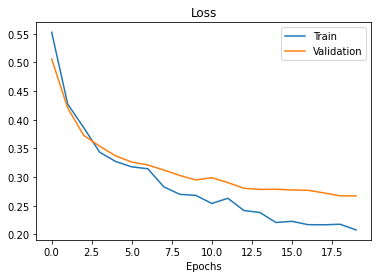

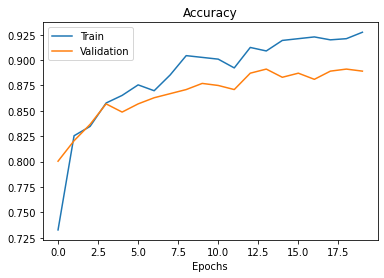

In [ ]:
import torchvision.models as models

# Set seeds for reproducibility
torch.manual_seed(121)
np.random.seed(121)

densenet121 = models.densenet121(pretrained=True)

# Repurpose Model
densenet121.requires_grad_(True)
densenet121.classifier = nn.Linear(1024, 2)

args_dict = {
    "seed": 413,
    "gpu": True,
    "epochs": 20,
    "learn_rate": 0.001,
    "train_batch_size": 64,
    "val_batch_size": 64
}

train_loader, val_loader, test_loader = initialize_loader(0.7, 0.2, args_dict["train_batch_size"], args_dict["val_batch_size"])
dataloaders = {"train": train_loader, "validate": val_loader}

learned_parameters = []
for name, param in densenet121.named_parameters():
    if name.startswith("classifier"):
        learned_parameters.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learned_parameters, lr=args_dict["learn_rate"], weight_decay=1e-4)

torch.cuda.empty_cache()
CovidDN121 = train(args_dict, densenet121, dataloaders, criterion, optimizer)

## Test Performance

In [ ]:
test_acc, test_loss = test_model(CovidDN121, True, test_loader, criterion)
print("Test loss: ", test_loss, "Test accuracy: ", test_acc)

False positive rate: 0.07246376811594203
False negative rate: 0.032
Test loss:  0.19435040652751923 Test accuracy:  0.9437751004016064


# Model: Densenet-161

Validation Loss:  0.6362608363551479  Validation Accuracy:  0.6935483870967742
Validation Loss:  0.5628592064303737  Validation Accuracy:  0.7983870967741935
Validation Loss:  0.5114713657286859  Validation Accuracy:  0.8366935483870968
Validation Loss:  0.4741778498695743  Validation Accuracy:  0.8467741935483871
Validation Loss:  0.44747754066221174  Validation Accuracy:  0.8528225806451613
Validation Loss:  0.4295743703842163  Validation Accuracy:  0.8669354838709677
Validation Loss:  0.40507014143851494  Validation Accuracy:  0.8669354838709677
Validation Loss:  0.39213837923542144  Validation Accuracy:  0.8729838709677419
Validation Loss:  0.3782140295351705  Validation Accuracy:  0.8588709677419355
Validation Loss:  0.3668819704363423  Validation Accuracy:  0.875
Validation Loss:  0.3595253546391764  Validation Accuracy:  0.8629032258064516
Validation Loss:  0.35261567657993687  Validation Accuracy:  0.8810483870967742
Validation Loss:  0.34947831496115656  Validation Accuracy:  

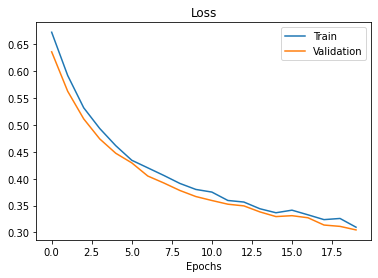

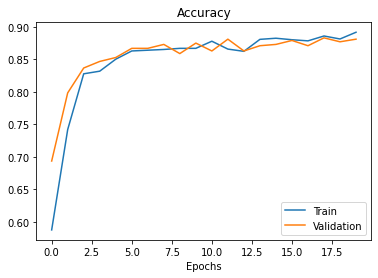

In [ ]:
import torchvision.models as models

# Set seeds for reproducibility
torch.manual_seed(161)
np.random.seed(161)

densenet161 = models.densenet161(pretrained=True)

# Repurpose Model
densenet161.requires_grad_(True)
densenet161.classifier = nn.Linear(2208, 2)

args_dict = {
    "seed": 413,
    "gpu": True,
    "epochs": 20,
    "learn_rate": 0.0001,
    "train_batch_size": 32,
    "val_batch_size": 32
}

train_loader, val_loader, test_loader = initialize_loader(0.7, 0.2, args_dict["train_batch_size"], args_dict["val_batch_size"])
dataloaders = {"train": train_loader, "validate": val_loader}

learned_parameters = []
for name, param in densenet161.named_parameters():
    if name.startswith("classifier"):
        learned_parameters.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learned_parameters, lr=args_dict["learn_rate"], weight_decay=1e-4)

torch.cuda.empty_cache()
CovidDN161 = train(args_dict, densenet161, dataloaders, criterion, optimizer)

## Test Performance

In [ ]:
test_acc, test_loss = test_model(CovidDN161, True, test_loader, criterion)
print("Test loss: ", test_loss, "Test accuracy: ", test_acc)

False positive rate: 0.11940298507462686
False negative rate: 0.07746478873239436
Test loss:  0.3077346086502075 Test accuracy:  0.891566265060241


# Model Inception v3

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Validation Loss:  0.5216270550604789  Validation Accuracy:  0.7762096774193549
Validation Loss:  0.4591653914220871  Validation Accuracy:  0.8145161290322581
Validation Loss:  0.41362567294028496  Validation Accuracy:  0.8407258064516129
Validation Loss:  0.3910240651138367  Validation Accuracy:  0.8528225806451613
Validation Loss:  0.38445192479318185  Validation Accuracy:  0.8568548387096774
Validation Loss:  0.38318642589353746  Validation Accuracy:  0.8487903225806451
Validation Loss:  0.37924357383481916  Validation Accuracy:  0.8306451612903226
Validation Loss:  0.35500475956547645  Validation Accuracy:  0.8689516129032258
Validation Loss:  0.35060494369076145  Validation Accuracy:  0.8669354838709677
Validation Loss:  0.35287398003762765  Validation Accuracy:  0.8649193548387096
Validation Loss:  0.3464722950612345  Validation Accuracy:  0.8689516129032258
Validation Loss:  0.3640559373363372  Validation Accuracy:  0.8366935483870968
Validation Loss:  0.33878699233455045  Valid

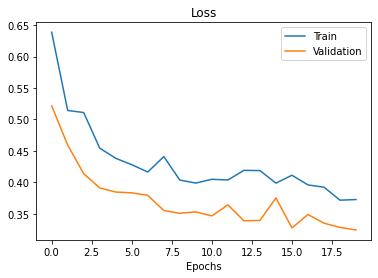

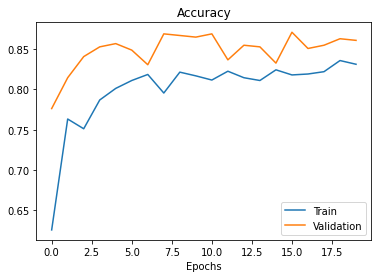

In [ ]:
import torchvision.models as models

# Set seeds for reproducibility
torch.manual_seed(3)
np.random.seed(3)

inception_v3 = models.inception_v3(pretrained=True, aux_logits=False)
inception_v3.Conv2d_1a_3x3 = nn.Sequential(
    nn.Upsample(size=299),
    inception_v3.Conv2d_1a_3x3
)

# Repurpose Model
inception_v3.requires_grad_(True)
inception_v3.fc = nn.Linear(2048, 2)

args_dict = {
    "seed": 413,
    "gpu": True,
    "epochs": 20,
    "learn_rate": 0.001,
    "train_batch_size": 32,
    "val_batch_size": 32
}

train_loader, val_loader, test_loader = initialize_loader(0.7, 0.2, args_dict["train_batch_size"], args_dict["val_batch_size"])
dataloaders = {"train": train_loader, "validate": val_loader}

learned_parameters = []
for name, param in inception_v3.named_parameters():
    if name.startswith("fc"):
        learned_parameters.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learned_parameters, lr=args_dict["learn_rate"], weight_decay=1e-4)

torch.cuda.empty_cache()
Covidception = train(args_dict, inception_v3, dataloaders, criterion, optimizer)

In [ ]:
test_acc, test_loss = test_model(Covidception, True, test_loader, criterion)
print("Test loss: ", test_loss, "Test accuracy: ", test_acc)

False positive rate: 0.1357142857142857
False negative rate: 0.11724137931034483
Test loss:  0.3285953998565674 Test accuracy:  0.8554216867469879


# Works Cited

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html